In [138]:
from random import random

# to generate n points randomly
# this is the only input strategy I'm testing!
# It is nice in that the random function will never return the
# same x or y coordinate for any points
# (well, there is some probability, but it's really really small)

# Also, I just chose random in the interval 0 to 1
# This is still representative, as you could just multiply by any constant
# That would create a larger footprint, while the algorithm would work the same

def gen_random_points(n):
    points = []
    for i in range(n):
        p = (random(), random())
        points.append(p)
    return points

points = gen_random_points(100)

In [142]:
from math import sqrt

# this is just a naive search
# It calculates pairwise distance and returns the minimum
# it also returns the points comprising the minimum
def naive_strategy(points):
    min_distance = -1
    for i in range(len(points)):
        for j in range(i+1, len(points)):
            d_ij = sqrt((points[i][0] - points[j][0])**2 + (points[i][1] - points[j][1])**2)
            if (min_distance == -1) or (d_ij < min_distance):
                min_distance = d_ij
                closest_points = (i, j)
    return min_distance, closest_points

naive_strategy(points)

(0.013047110295159203, (12, 28))

In [468]:
# this is just for timing the performance, as I needed to combine both!
def naive_time(n):
    return naive_strategy(gen_random_points(n))

In [27]:
# a simple linear strategy, also for timing purposes
# does not compute the correct answer, although does 
# the operations for one outer for loop iteration
def linear_strategy(points):
    # just check against points[0]
    min_distance = -1
    p_0 = points[0]
    for i in range(1, len(points)):
        d_i0 = sqrt((p_0[0] - points[i][0])**2 + (p_0[1] - points[i][1])**2)
        if (min_distance == -1) or (d_i0 < min_distance):
            min_distance = d_i0
            closest_points = (i, 0)
    return min_distance, closest_points

def linear_time(n):
    return linear_strategy(gen_random_points(n))

In [70]:
# need a working merge sort implementation to make the divide and conquer
# I chose to do merge sort in place
def merge_sort(l, indices):
    # base case
    if len(l) > 1:
        midpoint = len(l)//2
        left_half = l[0:midpoint]
        left_indices = indices[0:midpoint]
        right_half = l[midpoint:len(l)]
        right_indices = indices[midpoint:len(l)]
        merge_sort(left_half, left_indices)
        merge_sort(right_half, right_indices)

        i = j = k = 0
        while i < len(left_half) and j < len(right_half):
            if left_half[i] <= right_half[j]:
                l[k] = left_half[i]
                indices[k] = left_indices[i]
                i += 1
                k += 1
            elif left_half[i] > right_half[j]:
                l[k] = right_half[j]
                indices[k] = right_indices[j]
                j += 1
                k += 1
        
        while i < len(left_half):
            l[k] = left_half[i]
            indices[k] = left_indices[i]
            i += 1
            k += 1

        while j < len(right_half):
            l[k] = right_half[j]
            indices[k] = right_indices[j]
            j += 1
            k += 1

In [113]:
# this function takes the list of indices and returns where each
# element is in the other list
# this is an important part of the tracking of the points
# otherwise would only be able to compute the distance!
def get_positions_in_list(x_indices, y_indices):
    d_x = {}
    d_y = {}

    for i in range(len(x_indices)):
        d_x[x_indices[i]] = i
        d_y[y_indices[i]] = i

    x_positions_in_y = []
    y_positions_in_x = []

    for i in range(len(x_indices)):
        x_positions_in_y.append(d_y[x_indices[i]])
        y_positions_in_x.append(d_x[y_indices[i]])

    return x_positions_in_y, y_positions_in_x

In [405]:
from math import floor, ceil

# recursive helper function to compute the closest pair of points
def closest_pair(p_x, p_y, x_indices, y_indices):
    x_positions_in_y, y_positions_in_x = get_positions_in_list(x_indices, y_indices)
    # base case:
    if len(p_x) <= 3:
        points = [(p_x[i], p_y[x_positions_in_y[i]]) for i in range(len(p_x))]
        d, points = naive_strategy(points)
        first_point = x_indices[points[0]]
        second_point = x_indices[points[1]]
        if first_point < second_point:
            best_points = (first_point, second_point)
        else:
            best_points = (second_point, first_point)
        return d, best_points

    # making left and right sets, keep track of indices as well
    Q_x = p_x[0:ceil(len(p_x)/2)]
    Q_x_indices = x_indices[0:ceil(len(p_y)/2)]

    Q_y = []
    Q_y_indices = []
    for i in range(len(p_y)):
        if y_indices[i] in Q_x_indices:
            Q_y.append(p_y[i])
            Q_y_indices.append(y_indices[i])

    R_x = p_x[ceil(len(p_x)/2):len(p_x)]
    R_x_indices = x_indices[ceil(len(p_x)/2):len(p_x)]

    R_y = []
    R_y_indices = []
    for i in range(len(p_y)):
        if y_indices[i] in R_x_indices:
            R_y.append(p_y[i])
            R_y_indices.append(y_indices[i])

    # recursive call on left and right
    q_d, q_points = closest_pair(Q_x, Q_y, Q_x_indices, Q_y_indices)
    r_d, r_points = closest_pair(R_x, R_y, R_x_indices, R_y_indices)

    # smallest of recursive distances
    delta = min(q_d, r_d)

    # right most point in Q, where the line L is drawn
    x_star = Q_x[-1]

    S = []
    for i in range(len(p_x)):
        if abs(p_x[i] - x_star) < delta:    # this includes x_star
            S.append(x_indices[i])
    
    # S always includes x_star, 
    # only worry about checking in S if at least one other point
    if len(S) > 1:
        S_y = []
        S_y_indices_in_p_y = []
        for i in range(len(p_y)):
            if y_indices[i] in S:
                S_y.append(p_y[i])
                S_y_indices_in_p_y.append(i)
        
        min_distance_in_s = -1
        for i in range(len(S_y)):
            for j in range(i+1, min(len(S_y), i+15)):   # the key line, where 15 makes it nlogn!
                x_i = p_x[y_positions_in_x[S_y_indices_in_p_y[i]]]      # complicated index tracking, but it works
                x_j = p_x[y_positions_in_x[S_y_indices_in_p_y[j]]]
                y_i = S_y[i]
                y_j = S_y[j]
                d_ij = sqrt((x_i - x_j)**2 + (y_i - y_j)**2)
                if (min_distance_in_s == -1) or (d_ij < min_distance_in_s):
                    min_distance_in_s = d_ij
                    first_point = y_indices[S_y_indices_in_p_y[i]]
                    second_point = y_indices[S_y_indices_in_p_y[j]]
                    if first_point < second_point:
                        closest_points_in_s = (first_point, second_point)
                    else:
                        closest_points_in_s = (second_point, first_point)
        
    # now we have the shortest distance in S if |S| > 1, compare against delta
    if (len(S) > 1) and (min_distance_in_s < delta):
        return min_distance_in_s, closest_points_in_s
    elif q_d < r_d:
        return q_d, q_points
    else:
        return r_d, r_points
    
# sets up the initial merge sorted x and y coordinate lists
# also tracks the original indices, as required
def divide_and_conquer_strategy(points):
    p_x = [x[0] for x in points]
    x_indices = list(range(len(points)))

    p_y = [x[1] for x in points]
    y_indices = list(range(len(points)))

    merge_sort(p_x, x_indices)
    merge_sort(p_y, y_indices)

    return closest_pair(p_x, p_y, x_indices, y_indices)

In [462]:
# this one is just for timing purposes again
def divide_and_conquer_time(n):
    divide_and_conquer_strategy(gen_random_points(n))

In [469]:
# with this block, you can compare the results
# of the naive vs the divide and conquer on n many random points
# I ran this on all sizes of n and many times
# They always return the same. Since there are roughly n^2 possible pairs of points
# odds of choosing correctly 1 time is 1/n^2
# As I did it at least 20 times on input of size 100,
# it is very safe to say that the algorithm is correct
# Odds of doing that would be really small!!
n = 100
points = gen_random_points(n)
print(naive_strategy(points))
print(divide_and_conquer_strategy(points))

(0.0015342947525849243, (4, 84))
(0.0015342947525849243, (4, 84))


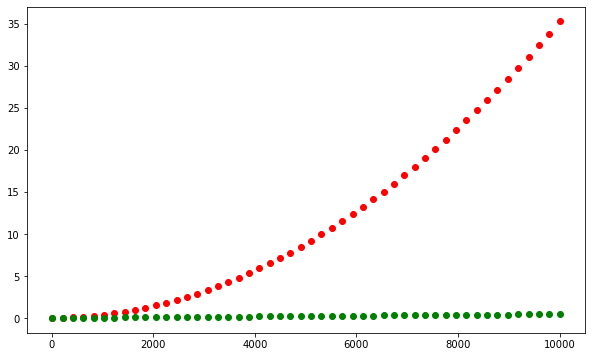

In [463]:
# this block is to produce the runtime plot
# I generate time series on 50 inputs with lenghts between 10 and 10,000 
# it also runs several times for each input, and displays the average

# I accidentally forgot to include the line for plotting the divide and conquer
# So I cleaned up the graph in the next code block
# This takes 15 mins to run (as naive search is very slow on 10,000 length inputs)
# so I did not bother running the calculations again

import matplotlib.pyplot as plt
import numpy as np
from timeit import timeit
from functools import partial

plt.rcParams['figure.figsize'] = [10, 6] # set size of plot

ns = np.linspace(10, 10000, 50, dtype=int)

naive_ts = [timeit(partial(naive_time, n), number=2) for n in ns]

divide_and_conquer_time_ts = [timeit(partial(divide_and_conquer_time, n), number=5) for n in ns]

linear_ts = [timeit(partial(linear_time, n), number=100) for n in ns]

plt.plot(ns, naive_ts, 'or')
plt.plot(ns, linear_ts, 'og')

Text(0.5, 1.0, 'Runtime comparison of Closest Points in Plane Algorithms')

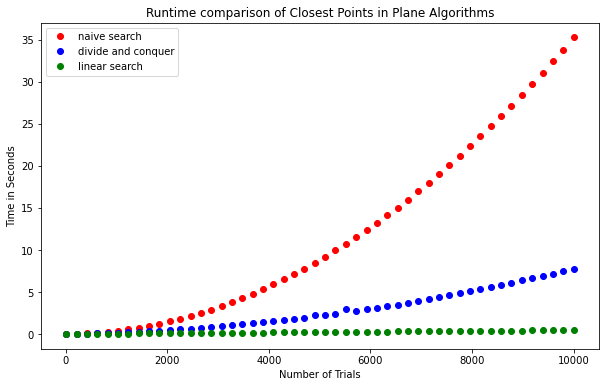

In [467]:
plt.plot(ns, naive_ts, 'or', label="naive search")
plt.plot(ns, divide_and_conquer_time_ts, 'ob', label="divide and conquer")
plt.plot(ns, linear_ts, 'og', label="linear search")
plt.xlabel("Number of Trials")
plt.ylabel("Time in Seconds")
plt.legend(loc="best")
plt.title("Runtime comparison of Closest Points in Plane Algorithms")
# For linear search, searched one vertex to all other vertices
# This does not produce the correct answer, but as the operations are the same,
# it does do a good job of showing linear time!